In [10]:
from multiinstance.data.realData import buildDataset
from multiinstance.utils import *
from multiinstance.gradientMethod import g1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [11]:
ds = buildDataset("/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/abalone.mat",size=2,
                  nPDistr=lambda:np.random.choice([100]),
                  nUDistr=lambda:np.random.choice([1000]),)

ds = addTransformScores(ds)
ds = addGlobalEsts(ds)
ds = addBagAlphaHats(ds)

KeyboardInterrupt: 

In [3]:
res = g1(ds)

In [4]:
np.mean(np.abs(res["alphaHats"].mean(1) - ds.trueAlphas.flatten()))

0.08890597764958041

In [5]:
np.mean(np.abs(ds.alphaHats.mean(1) - ds.trueAlphas.flatten()))

0.447620219003918

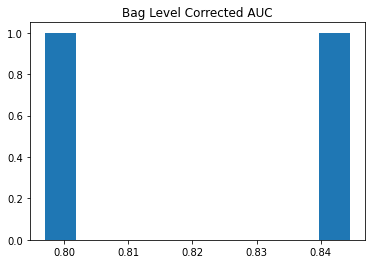

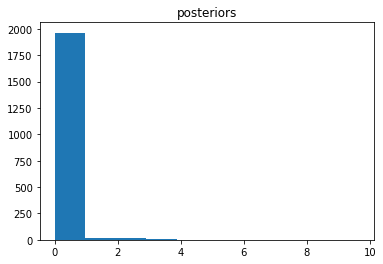

Text(0.5, 1.0, 'Transform Scores')

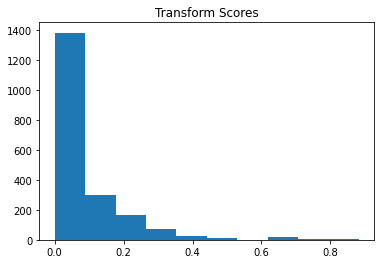

In [9]:
def posteriorCorrection(tau, alpha, S0S1):
    post =  alpha * S0S1 * (tau / (1 - tau))
    post[np.isinf(post)] = 1
    return post

def getROCInputs(ds,res):
    bagAlphaHats = ds.trueAlphas.flatten()#.mean(1)
    posTransforms, unlabeledTransforms = list(zip(*[getTransformScores(ds,i) for i in range(ds.N)]))
    S0S1 = ds.numU / ds.numP
    posteriors = [posteriorCorrection(tau,alphaHat, s0s1) for tau,alphaHat,s0s1 in zip(unlabeledTransforms,
                                                                                       bagAlphaHats,
                                                                                       S0S1)]
    posteriorVals = np.concatenate(posteriors)
    hiddenLabels = np.concatenate([ds.hiddenLabels[i][:ds.numU[i]] for i in range(ds.N)])
    return hiddenLabels, posteriorVals

def getAUCPU(Pprobs, Uprobs):
    labels = np.concatenate((np.ones_like(Pprobs),
                             np.zeros_like(Uprobs)))
    p = np.concatenate((Pprobs, Uprobs))
    return roc_auc_score(labels,p)

hL, posteriors = getROCInputs(ds,{})
alphaHats = res["alphaHats"].mean(1)
aucPU = np.array([getAUCPU(*getTransformScores(ds,i)) for i in range(ds.N)])
plt.hist((aucPU - (alphaHats/2)) / (1 - alphaHats))
plt.title("Bag Level Corrected AUC")
plt.show()
plt.clf()
plt.hist(posteriors)
plt.title("posteriors")
plt.show()
tauVals = np.concatenate([getTransformScores(ds,i)[1] for i in range(ds.N)])
plt.hist(tauVals)
plt.title("Transform Scores")

In [ ]:
tauVals.min(),tauVals.max()

In [ ]:
ds.numU / ds.numP

In [ ]:
.92 /.08 * 

In [12]:
.085/.228

0.37280701754385964